In [1]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales
Created on Thu Aug 22 11:58:39 2019

Proceso que automatiza reportes regionales, generando un documento word por cada region.

Obs: Se deben revisar los inputs antes de correr

@author: hugo.gallardo
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa              #Para conexión a BD, requerido para usar pd.read_sql()
import urllib                        #Para formatear string de conexión

import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl             # OJO EN LA CASA para importar excel como dataframe

from docx import Document
from docx import shared
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.text import WD_LINE_SPACING
from docxtpl import DocxTemplate, InlineImage   #rellenar templates

import seaborn as sns
import os
import sys
from pylab import savefig
import itertools

import pyodbc                               ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat
import querysGR as qg

In [2]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

# Verificar Drivers

###### DW ######

param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [3]:
# =============================================================================
# Creando parametros y funciones para queries 
# =============================================================================



url = 'C:/o/OneDrive - DCCP/Escritorio/Dpt Comunicaciones/Reportes Automatizados'
#os.chdir(url)
AnoReg = 2023

#Funcion para reducir un Anio
def Anomenos1(Ano):
    Menos = Ano - 1
    return Menos


#entra numero y retorna valor con puntos en string
#abrevia en millones si supera 8 dígitos
#agrega símbolos monetarios
def fmtoEntero(x, mnd=''):
    ini = ''
    fin = ''

    #abrevia si supera 8 digitos
    if x >= 100000000: #me pareció que muestre al menos 3 dígitos
        x = x / 1000000
        fin = ' millones'
    
    #verificar formato de escritura
    if mnd == 'CLP':
        ini = '$'
    elif mnd == 'USD':
        ini = 'US $'
        #fin = fin + ' USD'
    elif mnd == 'CLF':
        if fin == ' millones':
            fin = fin + ' de UF'
        else:
            fin = fin + ' UF'
    
    x = format(int(round(x)),',d') #crea str de entero con puntuación
    x = x.replace(",",".") #formato de puntos latino

    return ini + x + fin


#entra tasa y retorna el porcentaje como string
def fmtoPorcien(x):
    x = x * 100
    x = format(x,',.1f') #crea str con 1 decimal y puntuación
    x = x.replace(".","a").replace(",",".").replace("a",",") #formato de puntos latino
    return x+'%'


#Agrega gráfico de torta, necesita datos, etiqueta y título
def graf_torta(x, labels, titGraf): 
    plt.clf()
    #plt.figure(figsize=(4.5,4.5))
    bordeG = {'linewidth' : 1, 'edgecolor' : 'white'}
    plt.pie(x
            , autopct='%.1f%%'
            , textprops=dict(color="grey", size=7.7)
            , pctdistance=1.15
            , wedgeprops = bordeG)
    legend = plt.legend(labels
                        , loc = "lower center"
                        , bbox_to_anchor=(0.27, -0.15, 0.5, 0.5)
                        , ncols = 3
                        , fontsize=7
                        , handlelength=0.7
                        , handleheight=0.7
                        ) 
    tituloG = plt.title("Montos transados por sector " + titGraf ,fontweight="bold",fontsize=16)
    
    plt.savefig(titGraf+'.png')


#retorna string aumento/disminución según variacón entregada
def palabraVar(var):
    plb = 'una no variación' #es necesario?
    if var > 0:
        plb = 'un aumento'
    elif var < 0:
        plb = 'una disminución'
    return plb

###
### Funcion para definir si es mayor el top requerido o los datos del df
###

#Borrar
AnoRegM1 = Anomenos1(AnoReg)

#Si es semestral, agregar meses correspondientes
MesInferior = 1
MesSuperior = 11

#Agregar que semestre es:
Sem = "primer"
tri='primer' #'segundo' ,etc

anoReg = AnoReg
anoRegM = AnoRegM1

FechaQ = pd.Series([AnoReg,AnoRegM1, MesInferior,MesSuperior])

# =============================================================================
# Fin Inputs
# =============================================================================

In [4]:
# =============================================================================
# Setteo Diccionarios Regionales y Nacional
# =============================================================================
                                  
# Diccionario Regional, adaptar nombres de BBDD
# Usar BBDD? Renombrar para diccionario con mas datos??
RegNomb =  {'Antofagasta':              {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'la R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}

#nombres meses para usar con mes_i y mes_f (int)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 
         'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']


In [5]:
###########################################################
###    Def parámetros indicadores y ejecuvión querys    ###
###########################################################

#juntar parámetros al principio, querys al final. agregar condicionalidad a ejecución de querys

#Años y meses
anoReg = 2023
anoRegM = anoReg - 1
mes_i = 1
mes_f = 11


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])



In [6]:

#Totales Regionales 2023 ¿y 2022?
mndTotReg = 'CLP'
listColTmnReg = ['Tmn']
dtoTmnReg = 'tmnReg'


#Parametros Top Modalidad de compras
listColModReg = ['Mod']
dtoModReg = 'modReg'
topModReg = 9

#Query reg pa instituciones
topInsReg = 5
mndInsReg = 'CLP'
listColInsReg = ['Ins']
dtoInsReg = 'insReg'


#Proveedores
topPrvReg = 3
dtoPrvReg = 'prvReg'
listColPrvReg = ['Prv','PrvID']


#Montos Rubros Regionales
topRubReg = 3
mndRubReg = 'USD'
listColRubReg = ['Rub', 'Rank']
dtoRubReg = 'rubReg'


#Montos OC Regionales
listColOCReg = ['OCod', 'Ins', 'Prv', 'PrvID', 'Mtv', 'OLink']
dtoOCReg = 'ocReg'
topOCReg = 5
mndOCReg ='CLP'


#Montos Sectores Regionales
topSecReg = 4
mndSecReg = 'CLP'
listColSecReg = ['Sec']
dtoSecReg = 'secReg'


#Montos Compra Agils Regional 2022 y 2023
mndCAReg = 'CLP'



In [7]:

#---querys


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
TotReg = pd.read_sql(con = conn_DW,  sql = qg.queryTotalRegion(mes_i, mes_f) )
TotRegBig = pd.read_sql(con = conn_DW,  sql = qg.theQueryReg(mes_i, mes_f) ) #Reemplazar al de arriba?? demora
# se puede optimizar el tiempo de carga eliminando los requerimientos de para OC en theQueryReg()
#           opcionalmente se puede usar queryOrdenCompraRegionTop() para consultar las OC

#Montos Rubros Regionales
RubReg = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion(mes_i, mes_f, topRubReg) )

#Montos Compra Agils Regional 2022 y 2023
CAReg = pd.read_sql(con = conn_DW,  sql = qg.queryCompraAgilRegion(mes_i, mes_f) )


In [8]:

############################################################################################
###    Definición funciones creación diccionarios y contexto para llenado de template    ###
############################################################################################


#Settea diccionario contexto regional
def setContextoReg(r):
    ctxt = {}
    ctxt.update(RegNomb[r])
    return ctxt


#Retorna diccionario con total transado de monto y OC por región
#(dataframe filtrado por región, moneda a usar)
def agregarTotalesRegion(df, mnd):
    nctxt = {}
    
    regMndUSD   = df.loc[df['Año'] == anoReg, 'Monto_Bruto_USD'].iloc[0]     
    regMnd      = df.loc[df['Año'] == anoReg, 'Monto_Bruto_'+mnd].iloc[0]     
    regOC       = df.loc[df['Año'] == anoReg, 'CantOC'].iloc[0]               
    regMndM     = df.loc[df['Año'] == anoRegM, 'Monto_Bruto_'+mnd].iloc[0]    
    regOCM      = df.loc[df['Año'] == anoRegM, 'CantOC'].iloc[0]              

    nctxt['totRegUSD']      = fmtoEntero( regMndUSD , 'USD')
    nctxt['totReg'+mnd]     = fmtoEntero( regMnd    , mnd)
    nctxt['totRegOC']       = fmtoEntero( regOC     )
    nctxt['totReg'+mnd+'M'] = fmtoEntero( regMndM   , mnd)
    nctxt['totRegOCM']      = fmtoEntero( regOCM    )
    
    tasaVar                 = (regMnd - regMndM) / regMndM
    nctxt['totRegPct']      = fmtoPorcien(tasaVar)
    nctxt['totRegVarPlb']   = palabraVar(tasaVar)

    return nctxt


#Llama a creación de gráfico y retorna diccionario para agregarlo a template
#¿Pide moneda o dejamos default?
def agregarGrafMontoSectorRegion(df, titGraf):
    
    graf_torta(df['CLP'], df[''], titGraf)
    #pedir docu como parametro?
    img = InlineImage(docu, titGraf+'.png',width=Inches(6))
    dctGrf = {'secRegGrf' : img}
    return dctGrf


def agregarCARegion(df, mnd): 
    nctxt = {}

    # Dataframes año actual y anterior
    df0 = df.loc[df['Ano'] == anoReg] #MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
    dfM = df.loc[df['Ano'] == anoRegM]

    mto0    = df0['MONTO'+mnd+'_CAg'].iloc[0]
    oc0     = df0['CantOC_CAg'].iloc[0]
    mtoM    = dfM['MONTO'+mnd+'_CAg'].iloc[0]
    ocM     = dfM['CantOC_CAg'].iloc[0]

    mtoVar  = (mto0 - mtoM)/ mtoM   #Variacion monto
    ocDif   = oc0 - ocM             #Diferencia cantidad OC
    
    nctxt['caReg'+mnd]       = fmtoEntero(mto0, mnd)
    nctxt['caRegOC']         = fmtoEntero(oc0)
    nctxt['caReg'+mnd+'M']   = fmtoEntero(mtoM, mnd)
    nctxt['caRegOCM']        = fmtoEntero(ocM)
    nctxt['caReg'+mnd+'Var'] = fmtoPorcien(mtoVar)
    nctxt['caRegOCDif']      = fmtoEntero(ocDif)

    return nctxt


def extraerDataframe (df, r, listCol):
    df = df.loc[df['Region'] == r]
    listCol = ['Ano', 'Region'] + listCol
    
    df = df.groupby(listCol).agg({'USD' : sum,
                                  'CLP' : sum,
                                  'CLF' : sum,
                                  'OC'  : sum,})
    
    return df


def fmtoDataframe (df, listCol):
    df = df.reset_index()                               #reincorporar columnas del index
    df = df[df['Ano'] == 2023]                          #revisar cuando se usen mas años
    df = df.sort_values(by = 'USD', ascending = False)  #asegurar orden top
    df = df.reset_index()                               #reenumerar
    df = df.rename(columns = {listCol[0] : ''})         #formatea nombre de columna con dato de interés
    ###################################
    # BORRAR COL AÑO Y REGION E INDEX #
    ###################################
    return df


def dataframeDiciconario (df, dto, top=5):
    nctxt = {}

    tot = df['CLP'].sum() #total de referencia para porcentajes
    nctxt[dto+'TOTAL'] = fmtoEntero(tot, 'CLP') #referencia para comparar con otros cálculos

    if top > df.shape[0]:
        print('Cantidad de datos es menor a la requerida. ('+dto+')')
    top = min(top, df.shape[0]) #para que top no sea mayor a cantidad de datos

    df = df.head(top)

    for i,row in df.iterrows():
        #porcentaje del total 
        nctxt[dto+'Pct'+str(i+1)]   = fmtoPorcien((row['CLP']/tot)) 
        
        #pasa los datos del df
        for colu in df.columns:
            if colu in ['USD', 'CLP', 'CLF', 'OC']:
                nctxt[dto+colu+str(i+1)]     = [row[colu], colu]
            else:
                nctxt[dto+colu+str(i+1)]     = row[colu]

    for clave, valor in nctxt.items():

        if type(valor) == list:
            nctxt[clave] = fmtoEntero(valor[0], valor[1])
            
    return nctxt


#Importa datos especificados por solicitante para cada región, retorna un diccionario de diccionarios regionales con los datos
def impAdicionalesReg ():
    addReg = pd.read_excel(io = 'datosAdicionales.xlsx') #requiere también openpyxl
    return addReg.set_index('region').to_dict('index')




In [10]:
########################################
# Grafico Regional Sectores por 3 años #
########################################


ltSecRegAnos = [2023, 2022, 2021]
dfSecRegAnos = []
listSectores = pd.read_sql(con = conn_DW,  sql = qg.querySectores())

for i in range (0, len(ltSecRegAnos)):
    dfSecRegAnos.append(pd.read_sql(con = conn_DW,  sql = qg.querySectorRegion(mes_i, mes_f, ltSecRegAnos[i])))

dfSecRegAnos = pd.concat(dfSecRegAnos)
    

dfGlob = pd.DataFrame(dfSecRegAnos)
dfGlob.to_excel('SectoresRegionesAños.xlsx')

# sectores = []
# for i in range(len(listSectores)):
#     sectores.append(listSectores.iloc[i][0])

# anos_montos = {}

# print('')
# print('#-#')
# print('EMPIEZA REGIONES')
# print('#-#')
# print('')

# for r in listReg:
#     print(r)
#     rDFSecRegAnos = dfSecRegAnos.loc[dfSecRegAnos['Region']==r]
    
#     for i in range(len(ltSecRegAnos)):
#         rsDFSecRegAnos = rDFSecRegAnos.loc[rDFSecRegAnos['Ano']== 2023-i].sort_values(by=['Sec'])
#         anos_montos[str(2023-i)] = []
#         for row in rsDFSecRegAnos.iterrows():
#             anos_montos[str(2023-i)].append(row[1]['CLP'])
#         print(rsDFSecRegAnos)
#     print(anos_montos)
    


#     species = sectores #sectores
#     penguin_means = anos_montos
    
#     print(anos_montos)
#     x = np.arange(len(species))  # the label locations
#     width = 0.1  # the width of the bars
#     multiplier = 0

#     fig, ax = plt.subplots(layout='constrained')

#     for attribute, measurement in penguin_means.items():
#         offset = width * multiplier
#         rects = ax.bar(x + offset, measurement, width, label=attribute)
#         ax.bar_label(rects, padding=3)
#         multiplier += 1

#     # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Length (mm)')
#     ax.set_title('Penguin attributes by species')
#     ax.set_xticks(x + width, species)
#     ax.legend(loc='upper left', ncols=3)
#     ax.set_ylim(0, 1000000000)

#     plt.show()

In [ ]:
###################################################
###   Llenado diccionario/contexto y template   ###
###################################################

#Importar template
docu = DocxTemplate("docxtpl.docx")

#Settear diccionario nacional
contextoNac = {'ano' : str(anoReg),
               'anoM' : str(anoRegM),
               'mesI' : meses[mes_i - 1],   #llama nombre del mes para usar en reporte
               'mesF' : meses[mes_f - 1]}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

dicGlob = {}



#Iterador de regiones/documentos
for r in listReg:
    print('')
    print('##############')
    print(r)
    print('##############')

    contexto = setContextoReg(r)

    rTotReg = TotReg.loc[TotReg['Region'] == r]
    contexto.update(agregarTotalesRegion(rTotReg, mndTotReg))

    #tmn Reg
    rTmnReg = extraerDataframe (TotRegBig, r, listColTmnReg)
    rTmnReg = fmtoDataframe(rTmnReg, listColTmnReg)
    contexto.update(dataframeDiciconario(rTmnReg, dtoTmnReg))

    #modalidad de compra
    rModReg = extraerDataframe (TotRegBig, r, listColModReg)
    rModReg = fmtoDataframe(rModReg, listColModReg)    
    contexto.update(dataframeDiciconario(rModReg, dtoModReg, topModReg))

    
    # proveedores a los que se le compra por región
    rPrvReg = extraerDataframe (TotRegBig, r, listColPrvReg)
    rPrvReg = fmtoDataframe(rPrvReg, listColPrvReg) 
    contexto.update(dataframeDiciconario(rPrvReg, dtoPrvReg, topPrvReg))

    # top Instituciones reg
    rInsReg = extraerDataframe (TotRegBig, r, listColInsReg)
    rInsReg = fmtoDataframe(rInsReg, listColInsReg)    
    contexto.update(dataframeDiciconario(rInsReg, dtoInsReg, topInsReg))

    #top rubro por region (usa dataframe personalizado)
    rRubReg = extraerDataframe(RubReg, r, listColRubReg)
    rRubReg = fmtoDataframe(rRubReg, listColRubReg)
    contexto.update(dataframeDiciconario(rRubReg, dtoRubReg, topRubReg)) # el dato TOTAL de este diccionario no será congruente con los otros
                                                                             # pporque se usa otra query
    
    rOCReg = extraerDataframe(TotRegBig, r, listColOCReg)
    rOCReg = fmtoDataframe(rOCReg, listColOCReg)
    contexto.update(dataframeDiciconario(rOCReg, dtoOCReg, topOCReg))

    rSecReg = extraerDataframe(TotRegBig, r, listColSecReg)
    rSecReg = fmtoDataframe(rSecReg, listColSecReg)
    print(rSecReg)
    titGrafSecReg = contexto['nomCt'] + ' ' + str(anoReg)
    contexto.update(agregarGrafMontoSectorRegion(rSecReg, titGrafSecReg)) #remover grafico despues de renderizar
    contexto.update(dataframeDiciconario(rSecReg, dtoSecReg, topSecReg))

    rCAReg = CAReg.loc[CAReg['Region'] == r]
    contexto.update(agregarCARegion(rCAReg, mndCAReg))

    contexto.update(adicionalesReg[r])

    contexto.update(contextoNac)
    
    
    print(contexto)
    dicGlob.update({r: contexto})

    docu.render(contexto)
    #os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    #2023 plantilla cifras regionales
    nomDocu = contexto['ano'] + ' cifras regionales ' + contexto['nomCt'] + ' ' + contexto['mesI'] + '-' + contexto['mesF']
    docu.save('reportes/'+nomDocu+'.docx')

In [14]:
#######################################################
# Exporta planilla con todos los contextos regionales #
#######################################################

dfGlob = pd.DataFrame(dicGlob)
dfGlob.to_excel('dfGlob.xlsx')

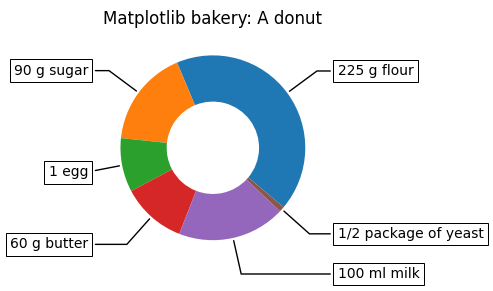

In [15]:
#####################################################
###    Referencia/Ejemplo para refinar gráfico    ###
#####################################################

#No afecta al programa
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["225 g flour",
          "90 g sugar",
          "1 egg",
          "60 g butter",
          "100 ml milk",
          "1/2 package of yeast"]

data = [225, 90, 50, 60, 100, 5]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()
#Fin Ref---------------------------------------------------------------------------------------------------------------------------------------------------------------------